# 📌 Assignment 1: Camera Calibration

`Live code works with this webpage, play around with the code.`

(There are multiple ways to read an image. Code for reading the image, is not a part of grading.)

In [10]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imageio.v3 as iio
from io import BytesIO
import numpy as np
from typing import List, Tuple
import cv2
import matplotlib.pyplot as plt

from cv2 import cvtColor, findChessboardCorners, cornerSubPix, drawChessboardCorners

# -------------------------------
# Async Pyodide fetch function
# -------------------------------
async def read_image_online(url: str) -> np.ndarray:
    from pyodide.http import pyfetch
    resp = await pyfetch(url=url, method="GET")
    data = BytesIO(await resp.bytes())
    return iio.imread(data, index=None)

# -------------------------------
# Offline standard fetch function
# -------------------------------
def read_image_offline(url: str) -> np.ndarray:
    return iio.imread(url, index=None)

# -------------------------------
# Load & show for online
# -------------------------------
async def load_and_show_online(url: str):
    img = await read_image_online(url)
    if img.ndim == 3:
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    else:
        img_rgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title("Loaded Image (RGB)")
    plt.axis('off')
    plt.show()

    return img_rgb

# -------------------------------
# Load & show for offline
# -------------------------------
def load_and_show_offline(url: str):
    img = read_image_offline(url)
    if img.ndim == 3:
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    else:
        img_rgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title("Loaded Image (RGB)")
    plt.axis('off')
    plt.show()

    return img_rgb

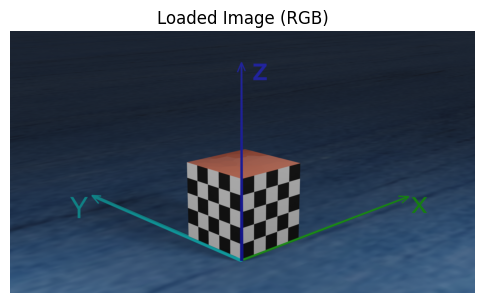

In [ ]:
# -------------------------------
# Config and run
# -------------------------------
online = True # Set True for online (webpage) interaction

IMAGE_URL = "https://raw.githubusercontent.com/naresh-ub/cvip/master/checkboard.png"

if online:
    img = await load_and_show_online(IMAGE_URL)
else:
    img = load_and_show_offline(IMAGE_URL)

## Chessboard Corner Detection

Before calibrating the camera, we need to detect reliable 2D points in the image.  
This function detects the **inner corners** of a chessboard pattern:

- Converts the input image to **grayscale**.
- Uses `findChessboardCorners` to locate approximate corner positions.
- Refines corners to **sub-pixel accuracy** with `cornerSubPix`.
- Visualizes the detected corners using Matplotlib in **RGB**.

The output is a `(N, 2)` array of pixel coordinates for all valid corners.  
These 2D points will later be matched with known 3D world coordinates to solve for the camera’s intrinsic and extrinsic parameters.

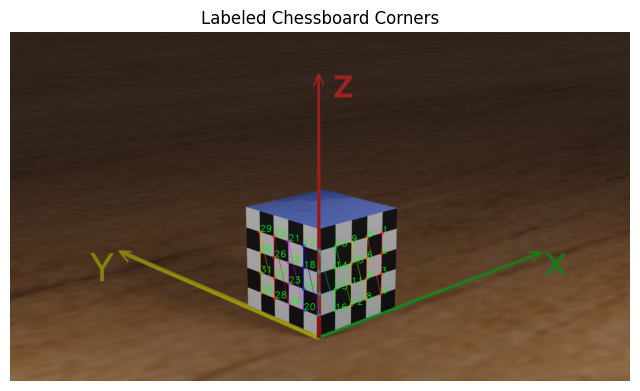

In [ ]:
def find_corner_img_coord(image: np.ndarray,
                           pattern_size: Tuple[int, int] = (4, 9),
                           text_params: dict = {
                               'fontFace': cv2.FONT_HERSHEY_DUPLEX,
                               'fontScale': 1.0,
                               'color': (0, 255, 0),
                               'thickness': 1
                           }) -> np.ndarray:
    """
    Find chessboard corners, filter unwanted ones, overlay index labels, and return final coordinates.

    Args:
        image: Input image (BGR).
        pattern_size: Tuple of (columns, rows) for inner corners.
        text_params: Dict for text overlay styling.

    Returns:
        (N, 2) numpy array of valid pixel coordinates.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    found, corners = cv2.findChessboardCorners(gray, pattern_size)
    if not found:
        raise ValueError("Chessboard corners not found.")

    # Refine corners to sub-pixel
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), criteria)

    # Draw corners on image
    image_with_corners = cv2.drawChessboardCorners(image.copy(), pattern_size, corners, found)

    # Remove unwanted edges
    corners = corners.reshape(-1, 2)
    corners_to_remove = [16, 17, 18, 19]  # Example: adjust based on your board

    valid_corners = []
    for idx, pt in enumerate(corners):
        if idx not in corners_to_remove:
            valid_corners.append(pt)

    # All we need are the valid corners
    valid_corners = np.array(valid_corners)
    
    # Part after this is just for visualization

    # Put index labels on image
    for display_idx, pt in enumerate(valid_corners, start=1):
        cv2.putText(
            image_with_corners,
            str(display_idx),
            (int(pt[0]), int(pt[1])),
            text_params['fontFace'],
            text_params['fontScale'],
            text_params['color'],
            text_params['thickness'],
            cv2.LINE_AA
        )

    # Show with Matplotlib in RGB
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
    plt.title("Labeled Chessboard Corners")
    plt.axis('off')
    plt.show()

    return valid_corners

corner_img_coords = find_corner_img_coord(img, pattern_size=(4, 9))

In [25]:
def find_corner_world_coord(img_coord: np.ndarray) -> np.ndarray:
    '''
    You can output the world coord manually or through some algorithms you design. Your output should be the same order with img_coord.
    Args: 
        img_coord: The image coordinate of the corners. Note that you do not required to use this as input, 
        as long as your output is in the same order with img_coord.
    Return:
        A numpy array of size 32x3 that represents the 32 checkerboard corners' pixel coordinates. 
        The world coordinate or each point should be in form of (x, y, z). 
        The axis of the world coordinate system are given in the image. The output results should be in milimeters.
    '''
    world_coord = np.zeros([32, 3], dtype=float)

    # Your implementation (manual or algorithmic) to find the world coordinates

    corners_from_image = [[40,0,40], [40,0,30], [40,0,20], [40,0,10], [30,0,40], [30,0,30], [30,0,20], [30,0,10], [20,0,40], [20,0,30],
           [20,0,20], [20,0,10], [10,0,40], [10,0,30], [10,0,20], [10,0,10], [0,10,40], [0,10,30], [0,10,20], [0,10,10],
           [0,20,40], [0,20,30], [0,20,20], [0,20,10], [0,30,40], [0,30,30], [0,30,20], [0,30,10], [0,40,40], [0,40,30],
           [0,40,20], [0,40,10]] # Manual (can be replaced with a nested loop or algorithm)


    world_coord = np.array(corners_from_image,dtype=float)
    return world_coord

corner_world_coords = find_corner_world_coord(img)

## Finding Camera Intrinsic Parameters

This function estimates the camera’s intrinsic parameters $(f_x, f_y, c_x, c_y)$ using known correspondences between image coordinates and world coordinates of the checkerboard corners.

### What It Does

- A camera projects 3D world points $\mathbf{X} = [X, Y, Z]^T$ into 2D image points $\mathbf{x} = [x, y]^T$ using the projection equation:
  
  $$
  s 
  \begin{bmatrix} 
  x \\ y \\ 1 
  \end{bmatrix}
  = 
  \mathbf{K} 
  [\mathbf{R} | \mathbf{T}] 
  \begin{bmatrix} 
  X \\ Y \\ Z \\ 1 
  \end{bmatrix}
  $$

  where $\mathbf{K}$ contains $f_x, f_y, c_x, c_y$.

### How It Works

1. Builds a large linear system by stacking projection equations for all 32 point correspondences.
2. Uses **Singular Value Decomposition (SVD)** to solve for the projection matrix that best explains the mapping.
3. Extracts the intrinsic parameters:
   - Principal point:
  
     $$
     c_x = \mathbf{m}_1^T \mathbf{m}_3, \quad
     c_y = \mathbf{m}_2^T \mathbf{m}_3
     $$

   - Focal lengths:

     $$
     f_x = \sqrt{\mathbf{m}_1^T \mathbf{m}_1 - c_x^2}, \quad
     f_y = \sqrt{\mathbf{m}_2^T \mathbf{m}_2 - c_y^2}.
     $$

---

### Output

Returns $f_x$, $f_y$, $c_x$, and $c_y$ which form the intrinsic camera matrix:

$$
\mathbf{K} = 
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}.
$$

In [22]:
def find_intrinsic(img_coord: np.ndarray, world_coord: np.ndarray) -> Tuple[float, float, float, float]:
    '''
    Use the image coordinates and world coordinates of the 32 point to calculate the intrinsic parameters.
    Args: 
        img_coord: The image coordinate of the 32 corners. This is a 32x2 numpy array.
        world_coord: The world coordinate of the 32 corners. This is a 32x3 numpy array.
    Returns:
        fx, fy: Focal length. 
        (cx, cy): Principal point of the camera (in pixel coordinate).
    '''

    fx: float = 0
    fy: float = 0
    cx: float = 0
    cy: float = 0

    # As we have 32 corner points, we need to create a matrix of size (2*n,12)
    matrix = np.zeros((64,12))

    for i in range(0,len(matrix)):
      
      if i % 2 == 0 : 
        matrix[i] = [world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,0,0,0,0,(-img_coord[i//2][0] * world_coord[i//2][0]),(-img_coord[i//2][0] * world_coord[i//2][1]),(-img_coord[i//2][0] * world_coord[i//2][2]),-img_coord[i//2][0]]
      else:
        matrix[i] = [0,0,0,0,world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,(-img_coord[i//2][1] * world_coord[i//2][0]),(-img_coord[i//2][1] * world_coord[i//2][1]),(-img_coord[i//2][1] * world_coord[i//2][2]),-img_coord[i//2][1]]
    
    matrix = np.array(matrix,dtype = float) 

    # Singular Value Decomposition of matrix

    u,s,vh = np.linalg.svd(matrix)
    vh = vh.reshape((12,12))

    # As per preliminary, we need to take the last row of V.T

    """
    According to preliminary, (r_i).T.dot(r_j)=I
    """

    right_matrix =np.reshape(vh[11],(3,4))
    last_row_of_x = right_matrix[2,0:3] 
    norm_of_x = np.linalg.norm(last_row_of_x)
    right_matrix_scaled = right_matrix/norm_of_x

    m11,m12,m13,m14,m21,m22,m23,m24,m31,m32,m33,m34 = tuple(right_matrix_scaled.flatten())

    m1 = np.array([[m11],[m12],[m13]])
    m2 = np.array([[m21],[m22],[m23]])
    m3 = np.array([[m31],[m32],[m33]])
    m4 = np.array([[m14],[m24],[m34]])


    # Solving for c_x and c_y

    cx = np.dot(m1.T,m3)[0][0]
    cy = np.dot(m2.T,m3)[0][0]

    # Solving for f_x and f_y

    temp1 = np.dot(m1.T,m1)[0][0]
    temp2 = cx**2

    fx = np.sqrt(temp1 - temp2)

    temp1 = np.dot(m2.T,m2)[0][0]
    temp2 = cy**2

    fy = np.sqrt(temp1 - temp2)

    return fx, fy, cx, cy

fx,fy,cx,cy = find_intrinsic(img_coord= corner_img_coords, world_coord= corner_world_coords)

print(fx,fy,cx,cy)

2782.7436964613917 2782.6372785394415 996.4023498351921 563.7371001203128


## Finding Camera Extrinsic Parameters

This function computes the **extrinsic parameters** — the **rotation matrix** $\mathbf{R}$ and the **translation vector** $\mathbf{T}$ — that describe the camera's pose in the world coordinate system.

### What It Does

- Uses known **image points** and **world points** (from the checkerboard) along with the **intrinsic matrix** to recover how the camera is **rotated and translated** relative to the world.
- Solves the same projection equations as for the intrinsic matrix but rearranges terms to isolate the extrinsic block.

### How It Works

1. Builds a **linear system** for projection just like in `find_intrinsic`.
2. Solves for the 3x4 projection matrix $\mathbf{M}$ using **Singular Value Decomposition (SVD)**.
3. Decomposes $\mathbf{M}$ using the known intrinsic matrix $\mathbf{K}$:
   
   $$
   \mathbf{M} = \mathbf{K} [\mathbf{R} | \mathbf{T}]
   $$

4. Extracts rotation:
   
   $$
   r_{ij} = \frac{m_{ij} - c \cdot m_{3j}}{f}
   \quad
   \text{and} \quad
   r_{3j} = m_{3j}
   $$

   where $f$ and $c$ are the focal length and principal point.
5. Extracts translation:
   
   $$
   t_x = \frac{m_{14} - c_x m_{34}}{f_x}, 
   \quad
   t_y = \frac{m_{24} - c_y m_{34}}{f_y},
   \quad
   t_z = m_{34}.
   $$

### Output

- $\mathbf{R}$: A $3 \times 3$ matrix that rotates world coordinates into the camera frame.
- $\mathbf{T}$: A vector of length 3 that translates the world origin into the camera frame.

Combined, they define the **pose** of the camera in the world.

In [23]:
def find_extrinsic(img_coord: np.ndarray, world_coord: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Use the image coordinates, world coordinates of the 32 point and the intrinsic parameters to calculate the extrinsic parameters.
    Args: 
        img_coord: The image coordinate of the 32 corners. This is a 32x2 numpy array.
        world_coord: The world coordinate of the 32 corners. This is a 32x3 numpy array.
    Returns:
        R: The rotation matrix of the extrinsic parameters. It is a 3x3 numpy array.
        T: The translation matrix of the extrinsic parameters. It is a 1-dimensional numpy array with length of 3.
    '''

    R = np.eye(3).astype(float)
    T = np.zeros(3, dtype=float)

    # Your implementation


    # Using the intrinsic parameters from the find_intrinsic function

    fx,fy,cx,cy = find_intrinsic(img_coord,world_coord)

    # Calculating the M matrix

    matrix = np.zeros((64,12))
    for i in range(0,len(matrix)):
      
      if i % 2 == 0 : 
        matrix[i] = [world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,0,0,0,0,(-img_coord[i//2][0] * world_coord[i//2][0]),(-img_coord[i//2][0] * world_coord[i//2][1]),(-img_coord[i//2][0] * world_coord[i//2][2]),-img_coord[i//2][0]]
      else:
        matrix[i] = [0,0,0,0,world_coord[i//2][0],world_coord[i//2][1],world_coord[i//2][2],1,(-img_coord[i//2][1] * world_coord[i//2][0]),(-img_coord[i//2][1] * world_coord[i//2][1]),(-img_coord[i//2][1] * world_coord[i//2][2]),-img_coord[i//2][1]]
    
    matrix = np.array(matrix,dtype = float) 


    u,s,vh = np.linalg.svd(matrix)
    vh = vh.reshape((12,12))

    """
    According to preliminary, (r_i).T.dot(r_j)=I
    """

    right_matrix =np.reshape(vh[11],(3,4))
    last_row_of_x = right_matrix[2,0:3] 
    norm_of_x = np.linalg.norm(last_row_of_x)
    right_matrix_scaled = right_matrix/norm_of_x

    m11,m12,m13,m14,m21,m22,m23,m24,m31,m32,m33,m34 = tuple(right_matrix_scaled.flatten())

    r11 = (m11 - (cx*m31))/fx
    r12 = (m12 - (cx*m32))/fx
    r13 = (m13 - (cx*m33))/fx
    r21 = (m21 - (cy*m31))/fy
    r22 = (m22 - (cy*m32))/fy
    r23 = (m23 - (cy*m33))/fy
    r31 = m31
    r32 = m32
    r33 = m33

    temp1 = (m14 -(cx*m34))/fx
    temp2 = (m24 -(cy*m34))/fy
    temp3 = m34

    R = [[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]]
    R = np.array(R,dtype = float)
    T = [temp1,temp2,temp3]
    T = np.array(T,dtype = float)

    return R, T

R,T = find_extrinsic(img_coord=corner_img_coords, world_coord=corner_world_coords)
print(R, T)

[[-7.29437695e-01  6.84047125e-01  4.23905897e-04]
 [ 1.77612915e-01  1.88809820e-01  9.65818049e-01]
 [-6.60585023e-01 -7.04579383e-01  2.59220604e-01]] [-1.07990265e-01 -5.77525766e+01 -3.81641982e+02]


## Validating Camera Calibration by Reprojection

Once we have both the **intrinsic** and **extrinsic** parameters, we can verify the calibration quality by projecting known 3D world points back onto the image plane and comparing them with the actual detected image points.

---

### `validate_projection`

- **Purpose:**  
  Uses the intrinsic matrix $\mathbf{K}$ and extrinsics $[\mathbf{R} | \mathbf{T}]$ to form the **camera projection matrix**:
  
  $$
  \mathbf{P} = \mathbf{K} [\mathbf{R} | \mathbf{T}]
  $$

- **Process:**  
  - Convert world points to homogeneous coordinates.
  - Apply $\mathbf{P}$ to map them into image space.
  - Normalize to get pixel coordinates.
  - Compare these with the original detected pixel locations.
  - Compute the **mean reprojection error** in pixels.

- **Good sign:**  
  A **low reprojection error** confirms that the camera parameters accurately map 3D world geometry into the image.

---

### `show_projection`

- **Purpose:**  
  Visualizes both the original detected points (**lime circles**) and the reprojected points (**red crosses**) on top of the image.
- Clear overlap means the camera matrix is a good fit.

---

Together, these steps are the final sanity check to ensure that your **camera calibration** is geometrically correct.


Mean Reprojection Error: 0.04 pixels


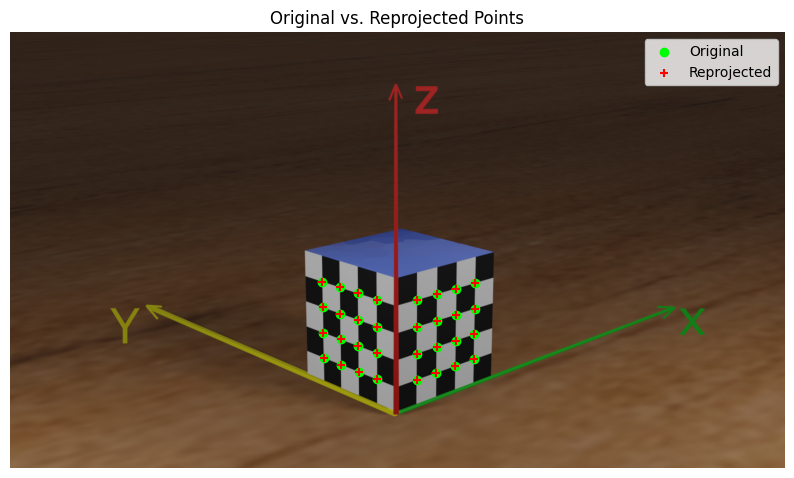

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def validate_projection(
    img_coord: np.ndarray,
    world_coord: np.ndarray,
    fx: float, fy: float, cx: float, cy: float,
    R: np.ndarray, T: np.ndarray
) -> np.ndarray:
    """
    Projects 3D world points into the image using given intrinsics & extrinsics.
    Computes reprojection error.

    Args:
        img_coord: (N, 2) image pixel coordinates (ground truth)
        world_coord: (N, 3) world coordinates in 3D
        fx, fy, cx, cy: intrinsic parameters
        R: (3, 3) rotation matrix
        T: (3, ) translation vector

    Returns:
        (N, 2) reprojected pixel coordinates
    """
    # Camera intrinsics
    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])

    # Projection matrix: P = K [R | T]
    P = K @ np.hstack((R, T.reshape(-1, 1)))

    # Convert world points to homogeneous coordinates
    world_homog = np.hstack([world_coord, np.ones((world_coord.shape[0], 1))])

    # Project to image plane
    projected = (P @ world_homog.T).T
    projected /= projected[:, 2].reshape(-1, 1)
    projected_2d = projected[:, :2]

    # Compute error
    error = np.linalg.norm(img_coord - projected_2d, axis=1)
    print(f"\nMean Reprojection Error: {np.mean(error):.2f} pixels")

    return projected_2d

def show_projection(
    img: np.ndarray,
    img_coord: np.ndarray,
    projected_2d: np.ndarray
):
    """
    Overlays original and reprojected points on the image.

    Args:
        img: input image (BGR)
        img_coord: original image points
        projected_2d: reprojected points
    """
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.scatter(img_coord[:, 0], img_coord[:, 1], c='lime', label='Original', marker='o')
    plt.scatter(projected_2d[:, 0], projected_2d[:, 1], c='red', label='Reprojected', marker='+')
    plt.title('Original vs. Reprojected Points')
    plt.legend()
    plt.axis('off')
    plt.show()

projected_2d = validate_projection(
    corner_img_coords, corner_world_coords, fx, fy, cx, cy, R, T
)
show_projection(img, corner_img_coords, projected_2d)